# Environment Setup

In [3]:
import gpytoolbox as gpy
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Dataset

## Random Sample

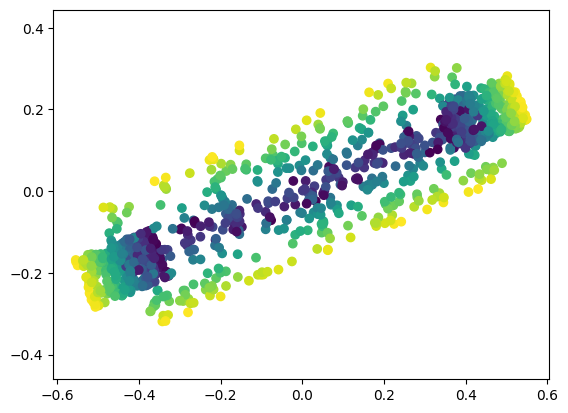

In [4]:
random_pts, normals = utils.generate_random_rectangle(1000)
X_coords, Y = utils.generate_pts_from_normals(random_pts, normals)
_ = plt.scatter(X_coords[:,0], X_coords[:,1], c=Y)
_ = plt.axis('equal')

## Generating dataset

100%|██████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:45<00:00, 2213.68it/s]


(-0.3720355272293091,
 0.3867152571678162,
 -0.30651008486747744,
 0.3074578583240509)

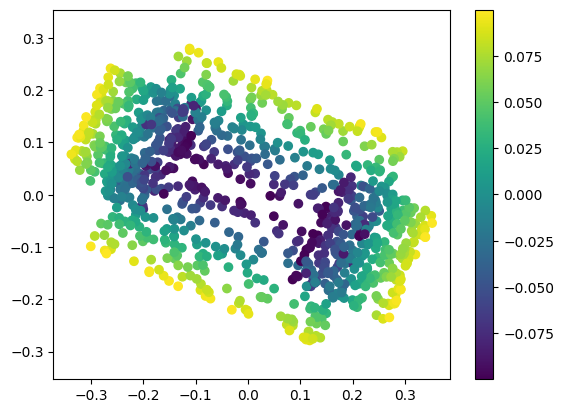

In [5]:
n_samples = 10**5
dataset = utils.RectData(num_samples=n_samples, size=1000, num_seed=None)

# Visualize data samples
grid, values = dataset[0]
plt.scatter(grid[:,0],grid[:,1],c=values,cmap="viridis")
plt.colorbar()
plt.axis('equal')

# Neural Process

## Creating Model

torch.Size([1, 10000, 1])


/tmp/ipykernel_43/660841821.py:40: UserWarning: No contour levels were found within the data range.
  plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')


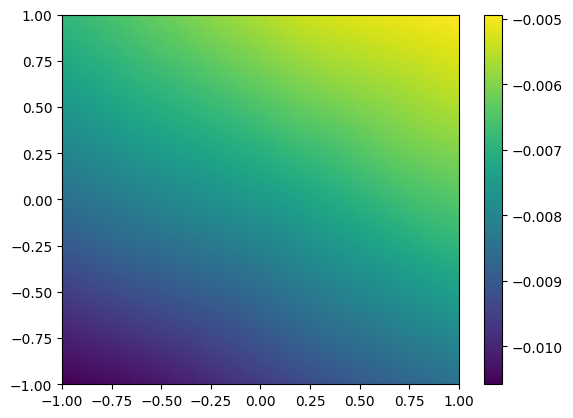

In [6]:
# Defining data dimensions
x_dim, y_dim = dataset.x_dim,dataset.y_dim

# Defining dim. of representation of context points
r_dim = 256

# Defining dim. of sampled latent variable
z_dim = 256

# Defining dim. of hidden layers
h_dim = 256

# Creating NP
neuralprocess = utils.HarmonicNeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim).to(device)

# Sampling from untrained NP
# Create a set of 100 target points, with shape
# (batch_size, num_points, x_dim), which in this case is
# (1, 10000, 2)
xs = np.linspace(-1,1,100)
ys = np.linspace(-1,1,100)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
grid = np.vstack((Xs,Ys)).T

x_target = torch.Tensor(grid).reshape(1,100**2,2).to(device)

for i in range(1):
    z_sample = torch.randn((1, z_dim)).to(device)  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a
    # normal with mean mu and std dev sigma)
    #embeds = neuralprocess.harmonic_embedding(x_target)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    print(mu.shape)
    plt.pcolormesh(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),shading='gouraud',cmap="viridis")
    plt.colorbar()
    plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')

## Training Model

In [7]:
# Defining training params.
batch_size = 100
num_context = 100
num_target = 900

# Creating data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Creating optimizer
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

# Creating Trainer
np_trainer = utils.NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target),
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 5)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.01batch/s, loss=-1.24e+3]


Epoch: 0, Avg_loss: -1186.6210625333786


Epoch 1: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [01:51<00:00,  8.94batch/s, loss=-1.3e+3]


Epoch: 1, Avg_loss: -1271.4993994140625


Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.88batch/s, loss=-1.32e+3]


Epoch: 2, Avg_loss: -1313.2275324707032


Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.92batch/s, loss=-1.34e+3]


Epoch: 3, Avg_loss: -1329.106479248047


Epoch 4: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.86batch/s, loss=-1.33e+3]

Epoch: 4, Avg_loss: -1336.7987492675782


## Testing Model

### Generate random test sample

(20, 2)


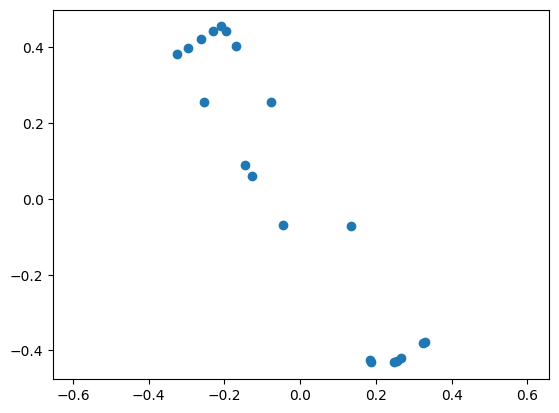

In [8]:
N_samples = 20

x_test, _ = utils.generate_random_rectangle(N_samples)
_ = plt.scatter(x_test[:,0], x_test[:,1])
_ = plt.axis('equal')
print(x_test.shape)

### Prediction

torch.Size([1, 20, 2])
torch.Size([1, 20, 1])
torch.Size([1, 10000, 2])
torch.Size([1, 10000, 1])


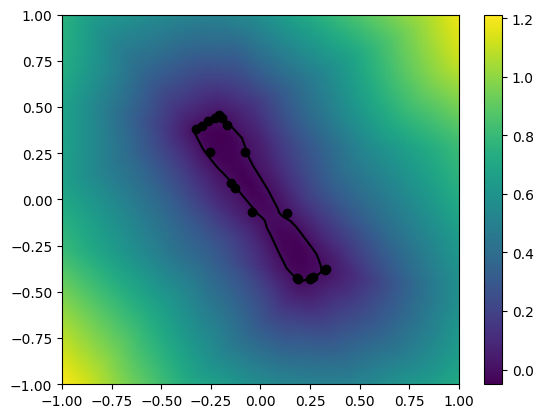

In [9]:
X = torch.Tensor(x_test).reshape((1,N_samples,2)).to(device)
y = torch.zeros((1,X.shape[1],1)).to(device)
print(X.shape)
print(y.shape)

# Create a set of target points corresponding to entire [-pi, pi] range
xs = np.linspace(-1,1,100)
ys = np.linspace(-1,1,100)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
grid = np.vstack((Xs,Ys)).T

x_target = torch.Tensor(grid).reshape(1,100**2,2).to(device)
#x_target = x_target.unsqueeze(1).unsqueeze(0)
print(x_target.shape)

neuralprocess.training = False


# Neural process returns distribution over y_target
p_y_pred = neuralprocess( X, y, x_target)
# Extract mean of distribution
mu = p_y_pred.loc.detach()
#plt.plot(x_target.numpy()[0], mu.numpy()[0],
#         alpha=1, c='b')

print(mu.shape)
X = X.cpu()
plt.pcolormesh(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),shading='gouraud',cmap="viridis")
plt.colorbar()
plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')
plt.scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c='k')